# Survival analysis: a machine learning approach using scikit-survival

## Introduction

Survival analysis is a branch of statistics that analyses the expected duration of time till one or more events will happen. While less well-known as classification approaches to these kind of questions, its outcomes are far richer: estimated probabilties that an event will happen during any time interval, expected remaining lifetime,... . Its all in there! In this notebook, I present a survival machine learning approach to predict customer churn. 

The goals of this notebook are threefold: 
- setting-up a machine learning pipeline for survival analysis, 
- comparing different survival machine learning models according to different performance metrics, 
- compare survival machine learning outcomes with classification exercises. 

I will not go over the basics of survival analysis again. If you are interested in these, I invite you to take a look at the notebook survival-basics.ipynb.

Have a nice read,   
  
Robrecht

## Setting-up work environment

In [1]:
import os
import csv
print(os.getcwd())

import pandas as pd
import numpy as np
from scipy import stats
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import lifelines
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import NelsonAalenFitter

import sksurv

%run "helper-functions";

C:\Users\vande70\OneDrive - Cronos 1\Cursussen\Survival Analysis\code


In [2]:
churn = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID', na_values=[' '])
print(churn.shape)
print(churn.head())
#print(churn.isnull().sum()

(7043, 20)
            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes          

## Data cleaning

### Correct types

In [3]:
churn[churn.select_dtypes(['object']).columns] = churn.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [4]:
# Set churn as numeric as categorical variables are not admitted by a lot of models
pd.value_counts(churn['Churn'])
churn["Churn"] = np.where(churn['Churn']=='Yes', 1, 0)
print(pd.value_counts(churn['Churn']) / len(churn))

0    0.73463
1    0.26537
Name: Churn, dtype: float64


In [5]:
churn["SeniorCitizen"] = np.where(churn['SeniorCitizen']==1, 'Yes', 'No')
churn["SeniorCitizen"] = churn["SeniorCitizen"].astype('category')
print(pd.value_counts(churn['SeniorCitizen']))

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64


### Data cleaning

In [6]:
for i in churn.select_dtypes(include='category'):
    print(pd.value_counts(churn[i]))
for i in churn.select_dtypes(include=['int64', 'float']):
    print(churn[i].describe())

Male      3555
Female    3488
Name: gender, dtype: int64
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
No                     2810
Yes            

We remove all tenure equal to zero as these cannot be accepted by some models and are quite absurd to use. 

In [7]:
churn = churn[churn['tenure'] > 0]
print(churn[['tenure', 'Churn']].describe())

            tenure        Churn
count  7032.000000  7032.000000
mean     32.421786     0.265785
std      24.545260     0.441782
min       1.000000     0.000000
25%       9.000000     0.000000
50%      29.000000     0.000000
75%      55.000000     1.000000
max      72.000000     1.000000


Now, we move on by inspecting the missings. There seems to be no missings, hence easy peasy go

In [8]:
print(churn.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Final cleaning operation, lets clean-up the content of the categorical variables. Can be usefull for later one-hot-encoding.

In [9]:
for i, colnames in enumerate(churn.select_dtypes(include='category')):
    churn[colnames] = churn[colnames].apply(lambda x: cleaning(x))
print(churn.head())

            gender SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                 
7590-VHVEG  female            no     yes         no       1           no   
5575-GNVDE    male            no      no         no      34          yes   
3668-QPYBK    male            no      no         no       2          yes   
7795-CFOCW    male            no      no         no      45           no   
9237-HQITU  female            no      no         no       2          yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  no_phone_service             dsl             no          yes   
5575-GNVDE                no             dsl            yes           no   
3668-QPYBK                no             dsl            yes          yes   
7795-CFOCW  no_phone_service             dsl            yes           no   
9237-HQITU 

### Select correct sample (row-wise and column-wise)

Since there are no missings and we filtered allready all observations with tenure equal to zero, we only check some columns. Most importantly to see if there is some multicollinearity. First, lets take a look at the correlations between the continuous variables.

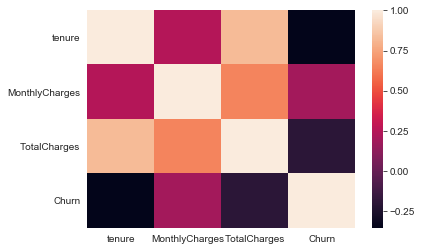

In [10]:
corr_mat = churn.corr()

sns.heatmap(corr_mat, 
            xticklabels=corr_mat.index.values,
            yticklabels=corr_mat.columns.values)
plt.show()

Second, lets take a look at the association between the categorical variables.

In [11]:
print('Cramers V:', cramers_v(cat1='SeniorCitizen', cat2='Contract', data=churn))

Cramers V: 0.1421771426428549


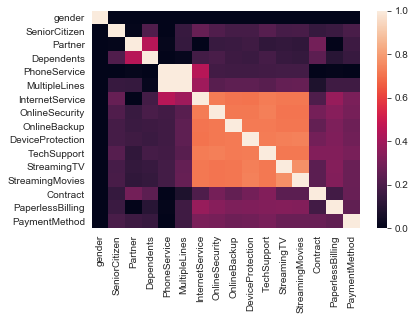

In [12]:
cat = churn.select_dtypes(include='category').columns
cramersv_mat = pd.DataFrame(index=cat, columns=cat)
cramersv_mat = cramersv_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cat):
        cramersv_mat.iloc[i, u] = cramers_v(cat1=j, cat2=v, data=churn)

sns.heatmap(cramersv_mat, 
            xticklabels=cramersv_mat.columns.values,
            yticklabels=cramersv_mat.index.values)
plt.show()
#print(cramersv_mat)

Last, lets take a look at the association between a categorical and continuous variable.

In [13]:
print('Correlation Ratio:', correlation_ratio(cat='SeniorCitizen', cont='MonthlyCharges', data=churn))

Correlation Ratio: 0.04834467680083301


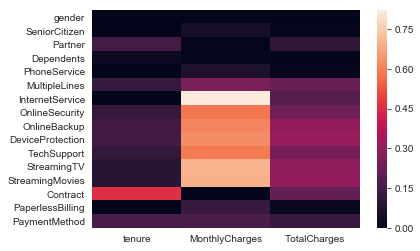

In [14]:
# In matrix
cat = churn.select_dtypes(include='category').columns
cont = churn.select_dtypes(include=['int64', 'float']).columns
corratio_mat = pd.DataFrame(index=cat, columns=cont)
corratio_mat = corratio_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cont):
        corratio_mat.iloc[i, u] = correlation_ratio(cat=j, cont=v, data=churn)

sns.heatmap(corratio_mat, 
            xticklabels=corratio_mat.columns.values,
            yticklabels=corratio_mat.index.values)
plt.show()
#print(corratio_mat)

Based on the above analysis, we decide to drop a few variables as they appear to be to highly associated with the other ones. We drop Total Charges rather than Monthly Charges because the former may already include some information on survival (the longer you are a customer, the higher your expected total charges.

In [15]:
to_drop = ['TotalCharges', 'PhoneService']
churn.drop(churn[to_drop], axis=1, inplace=True)

## Descriptive statistics

In [19]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


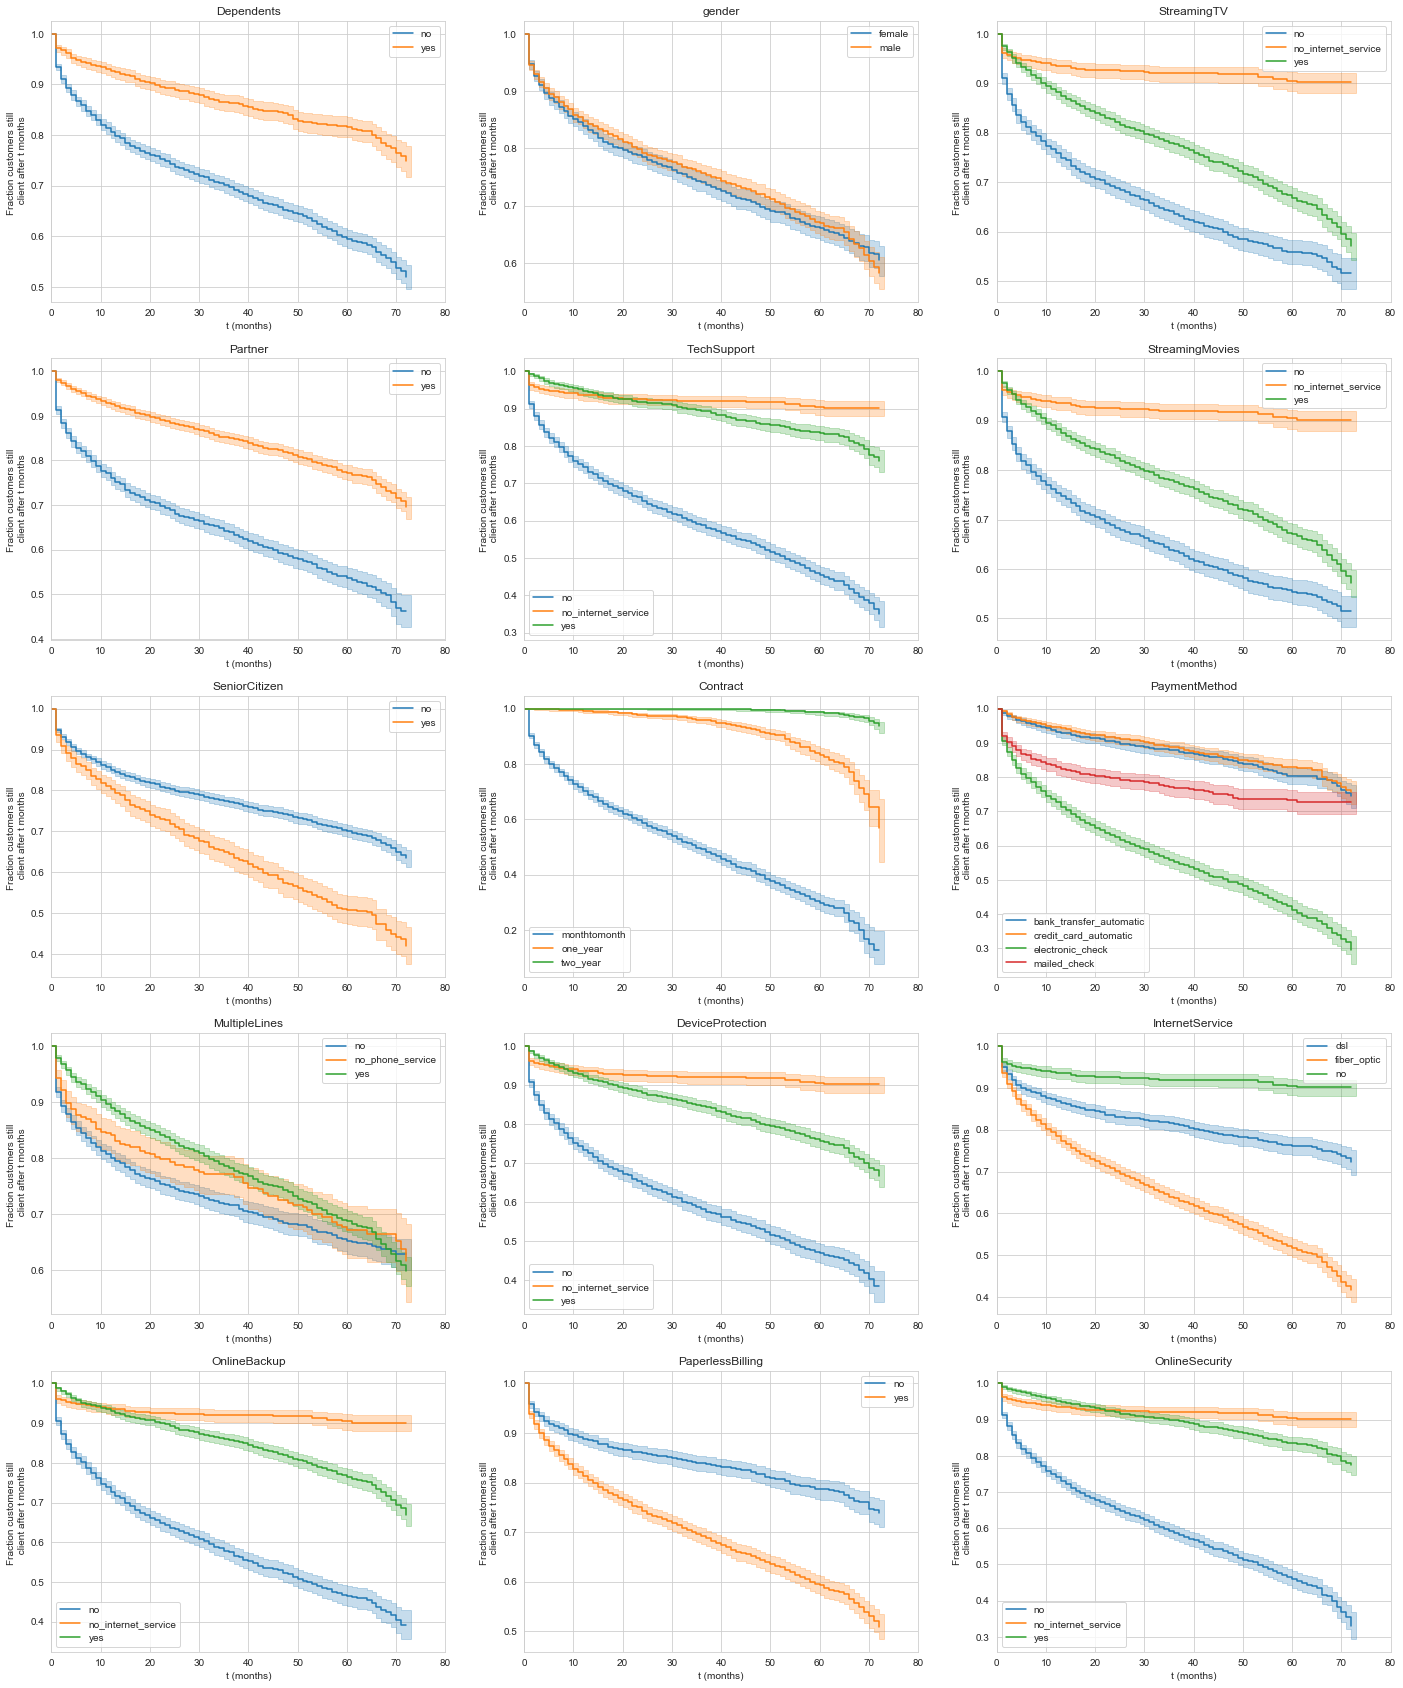

In [20]:
xvars = list(set(churn.select_dtypes(include='category').columns) - set(['tenure', 'Churn']))
fig_rows = np.ceil(len(xvars)/3)
fig_cols = np.ceil(len(xvars)/fig_rows)
plt.figure(figsize=(fig_cols*8, fig_rows*6))

for i, xvar in enumerate(xvars):
    ax = plt.subplot(fig_rows, 3, i+1)
    for name, grouped_df in churn.groupby(xvar):
        kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
        kmf.plot(ax=ax, legend=True)
        plt.title(xvar)
        plt.xlim(0, 80)
        plt.ylabel('Fraction customers still \n client after t months')
        plt.xlabel('t (months)')

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


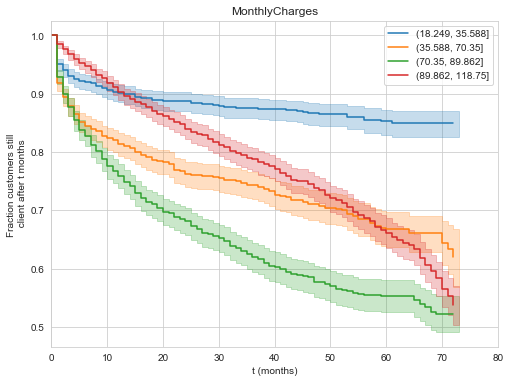

In [21]:
xvars = list(set(churn.select_dtypes(include=['int64', 'float']).columns) - set(['tenure', 'Churn']))
fig_rows = np.ceil(len(xvars)/3)
fig_cols = np.ceil(len(xvars)/fig_rows)
plt.figure(figsize=(fig_cols*8, fig_rows*6))

for i, xvar in enumerate(xvars):
    ax = plt.subplot(fig_rows, fig_cols, i+1)
    churn['xvar_binned'] = pd.qcut(churn[xvar], q = [0, 0.25, 0.5, 0.75, 1])
    for name, grouped_df in churn.groupby('xvar_binned'):
        kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
        kmf.plot(ax=ax, legend=True)
        plt.title(xvar)
        plt.xlim(0, 80)
        plt.ylabel('Fraction customers still \n client after t months')
        plt.xlabel('t (months)')
    churn.drop('xvar_binned', axis=1, inplace=True)

## Survival machine learning

Now, that we have covered data cleaning and descriptive statistics, its time to start modelling. 

### Data transformation

In [22]:
from sksurv.preprocessing import OneHotEncoder
churn_onehot = OneHotEncoder().fit_transform(churn)
churn_onehot.head()

,gender=male,SeniorCitizen=yes,Partner=yes,Dependents=yes,tenure,MultipleLines=no_phone_service,MultipleLines=yes,InternetService=fiber_optic,InternetService=no,OnlineSecurity=no_internet_service,...,StreamingMovies=no_internet_service,StreamingMovies=yes,Contract=one_year,Contract=two_year,PaperlessBilling=yes,PaymentMethod=credit_card_automatic,PaymentMethod=electronic_check,PaymentMethod=mailed_check,MonthlyCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.85,0
5575-GNVDE,1.0,0.0,0.0,0.0,34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95,0
3668-QPYBK,1.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.85,1
7795-CFOCW,1.0,0.0,0.0,0.0,45,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.30,0
9237-HQITU,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,70.70,1


Due to the one-hot encoding, there may be some variables that become correlated (for example to no internet connection categories), hence we recreate a correlation matrix. 

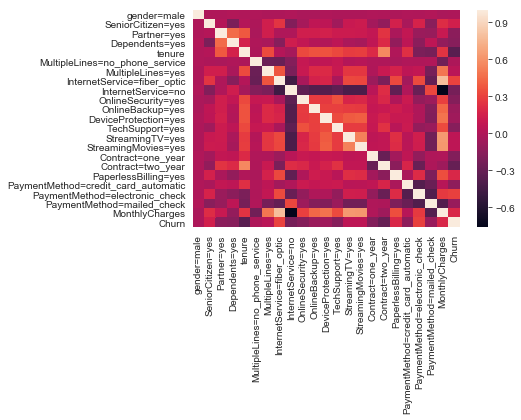

In [25]:
churn_cor = churn_onehot.corr()
sns.heatmap(churn_cor, 
            xticklabels=churn_cor.index.values,
            yticklabels=churn_cor.columns.values)
plt.show()

In [24]:
to_drop = churn_onehot.filter(regex='no_internet_service', axis=1).columns
print(to_drop)
churn_onehot.drop(to_drop, axis=1, inplace=True)

Index(['OnlineSecurity=no_internet_service',
       'OnlineBackup=no_internet_service',
       'DeviceProtection=no_internet_service',
       'TechSupport=no_internet_service', 'StreamingTV=no_internet_service',
       'StreamingMovies=no_internet_service'],
      dtype='object')


Now, we can can create our training (70% of samples) and test (30% of samples) dataset. As they are no time-varying covariates, we can easily split on observation.

In [26]:
y_vars = ['Churn', 'tenure']
y_data = np.array(churn_onehot[y_vars])
x_data = churn_onehot[list(set(churn_onehot.columns) - set(y_vars))]

dt = np.dtype([('Churn', np.bool_), ('tenure', np.float64)])
def convert_y(y):
    y_out = []
    for i in range(y.shape[0]):
        if y[i, 0]:
            y_out.append(('True', y[i, 1]))
        else:
            y_out.append(('False', y[i, 1]))
    y_out = np.array(y_out, dtype=dt)
    return y_out

y_data = convert_y(y_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=1234)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4922, 21)
(4922,)
(2110, 21)
(2110,)


### Cox proportional hazards model with Elastic Net regularization

We will start our machine learning exercise by estimating the Cox PH model with elastic net regularization (see Simon N, Friedman J, Hastie T, Tibshirani R. (2011)).

In [57]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
surv_coxnet = CoxnetSurvivalAnalysis(n_alphas=100, normalize=True)
surv_coxnet.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
            l1_ratio=0.5, max_iter=100000, n_alphas=100, normalize=True,
            penalty_factor=None, tol=1e-07, verbose=False)

In [63]:
surv_coxnet.alpha_min_ratio

0.0001

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

surv_cox = CoxnetSurvivalAnalysis(n_alphas=100)
cv_spec = KFold(n_splits=10, shuffle=True, random_state=1234)
param_grid = {'l1_ratio': np.arange(0.1, 1, 0.1), 
              'alpha_min_ratio': np.arange(0.1, 1, 0.1)}
#coxnet = CoxnetSurvivalAnalysis(n_alphas=100).fit(X_train, y_train)
gcv = GridSearchCV(surv_cox,
                   param_grid, 
                   cv = cv_spec)
gcv.fit(X_train, y_train)

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\model_selection\_validation.py:437: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vande70\AppData\Local\Continuum

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
       error_score='raise',
       estimator=CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, alphas=None, copy_X=True,
            l1_ratio=0.5, max_iter=100000, n_alphas=100, normalize=False,
            penalty_factor=None, tol=1e-07, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'alpha_min_ratio': array([1.00000e-05, 8.48343e-05, 7.19686e-04, 6.10540e-03, 5.17947e-02,
       4.39397e-01, 3.72759e+00, 3.16228e+01, 2.68270e+02, 2.27585e+03,
       1.93070e+04, 1.63789e+05, 1.38950e+06, 1.17877e+07, 1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [77]:
gcv.best_params_

{'alpha_min_ratio': 1e-05, 'l1_ratio': 0.1}

In [78]:
gcv.

AttributeError: 'GridSearchCV' object has no attribute 'alphas_'

In [82]:
results = pd.DataFrame(gcv.cv_results_)
print(results.head(n=10))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.004121      0.000213         0.008585        0.000269   
1       0.003963      0.000151         0.008523        0.000317   
2       0.004020      0.000230         0.008777        0.000254   
3       0.004066      0.000142         0.008424        0.000377   
4       0.003861      0.000392         0.008723        0.000463   
5       0.003822      0.000236         0.008773        0.000347   
6       0.003810      0.000245         0.008623        0.000296   
7       0.003917      0.000187         0.008718        0.000336   
8       0.004217      0.000398         0.008673        0.000496   
9       0.004163      0.000321         0.009021        0.001417   

  param_alpha_min_ratio param_l1_ratio  \
0                 1e-05            0.1   
1                 1e-05            0.2   
2                 1e-05            0.3   
3                 1e-05            0.4   
4                 1e-05            0.5   
5         

In [83]:
results.shape

(135, 32)

In [85]:
results = pd.DataFrame(gcv.cv_results_)
alphas = results.param_alpha_min_ratio.map(lambda x: x[0])
mean = results.mean_train_score
std = results.std_train_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_['alphas'][0], c='C1')
ax.grid(True)

IndexError: invalid index to scalar variable.

In [34]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]


None
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.   

### Gradient Boosting Survival Analysis

In [86]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
surv_cgbm = ComponentwiseGradientBoostingSurvivalAnalysis()
surv.gbm.fit(X_train, y_train)

C:\Users\vande70\AppData\Local\Continuum\anaconda3\envs\sksurv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


NameError: name 'surv' is not defined

## How does survival ml compares to classification ml?

## Summary